# MinDiff Model Remediation

In this notebook, we’ll train a text classifier to identify written content that could be considered toxic or harmful, and apply MinDiff to remediate some fairness concerns. In our workflow, we will:
1.   Evaluate our baseline model’s performance on text containing references to sensitive groups.
2.   Improve performance on any underperforming groups by training with MinDiff.
3.   Evaluate the new model’s performance on our chosen metric.

Our purpose is to demonstrate usage of the MinDiff technique with a very minimal workflow, not to lay out a principled approach to fairness in machine learning. As such, our evaluation will only focus on one sensitive category and a single metric. We also don’t address potential shortcomings in the dataset, nor tune our configurations. In a production setting, you would want to approach each of these with rigor. For more information on evaluating for fairness, see [this guide](https://www.tensorflow.org/responsible_ai/fairness_indicators/guide/guidance).


## Setup

We begin by installing Fairness Indicators and TensorFlow Model Remediation.


In [1]:
%pip install --upgrade tensorflow-model-remediation

Note: you may need to restart the kernel to use updated packages.


Import all necessary components, including MinDiff and Fairness Indicators for evaluation.

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [3]:
import copy
import os
import tempfile
import zipfile

# from fairness_indicators.tutorial_utils import util as fi_util
import numpy as np
import requests
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_model_remediation.min_diff as md
from tensorflow_model_remediation.tools.tutorials_utils import (
    min_diff_keras_utils,
)

# from tensorflow_model_analysis.addons.fairness.view import widget_view

We use a utility function to download the preprocessed data and prepare the labels to match the model’s output shape. The function also downloads the data as TFRecords to make later evaluation quicker. Alternatively, you may convert the Pandas DataFrame into TFRecords with any available utility conversion function.


In [4]:
# We use a helper utility to preprocessed data for convenience and speed.
(
    data_train,
    data_validate,
    validate_tfrecord_file,
    labels_train,
    labels_validate,
) = min_diff_keras_utils.download_and_process_civil_comments_data()

We define a few useful constants.  We will train the model on the `’comment_text’` feature, with our target label as `’toxicity’`. Note that the batch size here is chosen arbitrarily, but in a production setting you would need to tune it for best performance.

In [5]:
TEXT_FEATURE = "comment_text"
LABEL = "toxicity"
BATCH_SIZE = 512

Set random seeds. (Note that this does not fully stabilize results.)

In [6]:
# @title Seeds
np.random.seed(1)
tf.random.set_seed(1)

## Define and train the baseline model

To reduce runtime, we use a pretrained model by default. It is a simple Keras sequential model with an initial embedding and convolution layers, outputting a toxicity prediction. If you prefer, you can change this and train from scratch using our utility function to create the model. (Note that since your environment is likely different from ours, you would need to customize the tuning and evaluation thresholds.)

In [7]:
dataset_train_main = tf.data.Dataset.from_tensor_slices(
    (
        data_train["comment_text"].values,
        data_train[LABEL].values.reshape(-1, 1) * 1.0,
    )
).batch(BATCH_SIZE)

2023-12-14 16:53:43.195896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
hub_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
cnn_filter_sizes = [128, 128, 128]
cnn_kernel_sizes = [5, 5, 5]
cnn_pooling_sizes = [5, 5, 40]

baseline_model = tf.keras.Sequential()

# Embedding layer.
hub_layer = hub.KerasLayer(
    hub_url, output_shape=[128], input_shape=[], dtype=tf.string
)
baseline_model.add(hub_layer)
baseline_model.add(tf.keras.layers.Dense(128, activation="relu"))
baseline_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

baseline_model = min_diff_keras_utils.create_keras_sequential_model()

In [9]:
baseline_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

baseline_model.fit(x=dataset_train_main, batch_size=BATCH_SIZE, epochs=3)

Epoch 1/3
2116/2116 [==============================] - 31s 14ms/step - loss: 0.2336 - accuracy: 0.9223
Epoch 2/3
2116/2116 [==============================] - 29s 14ms/step - loss: 0.2255 - accuracy: 0.9237
Epoch 3/3
2116/2116 [==============================] - 29s 14ms/step - loss: 0.2231 - accuracy: 0.9244


We save the model in order to evaluate using [Fairness Indicators](https://www.tensorflow.org/responsible_ai/fairness_indicators).

In [10]:
# base_dir = tempfile.mkdtemp(prefix='saved_models')
# baseline_model_location = os.path.join(base_dir, 'model_export_baseline')
# baseline_model.save(baseline_model_location, save_format='tf')

Next we run Fairness Indicators. As a reminder, we’re just going to perform sliced evaluation for comments referencing one category, *religious groups*. In a production environment, we recommend taking a thoughtful approach to determining which categories and metrics to evaluate across.

To compute model performance, the utility function makes a few convenient choices for metrics, slices, and classifier thresholds.

In [11]:
# We use a helper utility to hide the evaluation logic for readability.
# base_dir = tempfile.mkdtemp(prefix='eval')
# eval_dir = os.path.join(base_dir, 'tfma_eval_result')
# eval_result = fi_util.get_eval_results(
#     baseline_model_location, eval_dir, validate_tfrecord_file)

###  Render Evaluation Results

In [12]:
# widget_view.render_fairness_indicator(eval_result)

Let’s look at the evaluation results. Try selecting the metric false positive rate (FPR) with threshold 0.450. We can see that the model does not perform as well for some religious groups as for others, displaying a much higher FPR. Note the wide confidence intervals on some groups because they have too few examples. This makes it difficult to say with certainty that there is a significant difference in performance for these slices. We may want to collect more examples to address this issue. We can, however, attempt to apply MinDiff for the two groups that we are confident are underperforming.

We’ve chosen to focus on FPR, because a higher FPR means that comments referencing these identity groups are more likely to be incorrectly flagged as toxic than other comments. This could lead to inequitable outcomes for users engaging in dialogue about religion, but note that disparities in other metrics can lead to other types of harm.

## Define and Train the MinDiff Model

Now, we’ll try to improve the FPR for underperforming religious groups. We’ll attempt to do so using [MinDiff](https://arxiv.org/abs/1910.11779), a remediation technique that seeks to balance error rates across slices of your data by penalizing disparities in performance during training. When we apply MinDiff, model performance may degrade slightly on other slices. As such, our goals with MinDiff will be:
*   Improved performance for underperforming groups
*   Limited degradation for other groups and overall performance



### Prepare your data

To use MinDiff, we create two additional data splits:
* A split for non-toxic examples referencing minority groups: In our case, this will include comments with references to our underperforming identity terms.  We don’t include some of the groups because there are too few examples, leading to higher uncertainty with wide confidence interval ranges.
* A split for non-toxic examples referencing the majority group.

It’s important to have sufficient examples belonging to the underperforming classes. Based on your model architecture, data distribution, and MinDiff configuration, the amount of data needed can vary significantly. In past applications, we have seen MinDiff work well with 5,000 examples in each data split.

In our case, the groups in the minority splits have example quantities of 9,688 and 3,906. Note the class imbalances in the dataset; in practice, this could be cause for concern, but we won’t seek to address them in this notebook since our intention is just to demonstrate MinDiff.  

We select only negative examples for these groups, so that MinDiff can optimize on getting these examples right. It may seem counterintuitive to carve out sets of ground truth *negative* examples if we’re primarily concerned with disparities in *false positive rate*, but remember that a false positive prediction is a ground truth negative example that’s incorrectly classified as positive, which is the issue we’re trying to address.

#### Create MinDiff DataFrames

In [13]:
# Create masks for the sensitive and nonsensitive groups
minority_mask = data_train.religion.apply(
    lambda x: any(religion in x for religion in ("jewish", "muslim"))
)
majority_mask = data_train.religion.apply(lambda x: x == "['christian']")

# Select nontoxic examples, so MinDiff will be able to reduce sensitive FP rate.
true_negative_mask = data_train["toxicity"] == 0

data_train_main = copy.copy(data_train)
data_train_sensitive = data_train[minority_mask & true_negative_mask]
data_train_nonsensitive = data_train[majority_mask & true_negative_mask]

We also need to convert our Pandas DataFrames into Tensorflow Datasets for MinDiff input.  Note that unlike the Keras model API for Pandas DataFrames, using Datasets means that we need to provide the model’s input features and labels together in one Dataset. Here we provide the `'comment_text'` as an input feature and reshape the label to match the model's expected output.

We batch the Dataset at this stage, too, since MinDiff requires batched Datasets.  Note that we tune the batch size selection the same way it is tuned for the baseline model, taking into account training speed and hardware considerations while balancing with model performance. Here we have chosen the same batch size for all three datasets but this is not a requirement, although it’s good practice to have the two MinDiff batch sizes be equivalent.

#### Create MinDiff Datasets

In [14]:
# Convert the pandas DataFrames to Datasets.
dataset_train_main = tf.data.Dataset.from_tensor_slices(
    (
        data_train_main["comment_text"].values,
        data_train_main.pop(LABEL).values.reshape(-1, 1) * 1.0,
    )
).batch(BATCH_SIZE)
dataset_train_sensitive = tf.data.Dataset.from_tensor_slices(
    (
        data_train_sensitive["comment_text"].values,
        data_train_sensitive.pop(LABEL).values.reshape(-1, 1) * 1.0,
    )
).batch(BATCH_SIZE)
dataset_train_nonsensitive = tf.data.Dataset.from_tensor_slices(
    (
        data_train_nonsensitive["comment_text"].values,
        data_train_nonsensitive.pop(LABEL).values.reshape(-1, 1) * 1.0,
    )
).batch(BATCH_SIZE)

## Viz

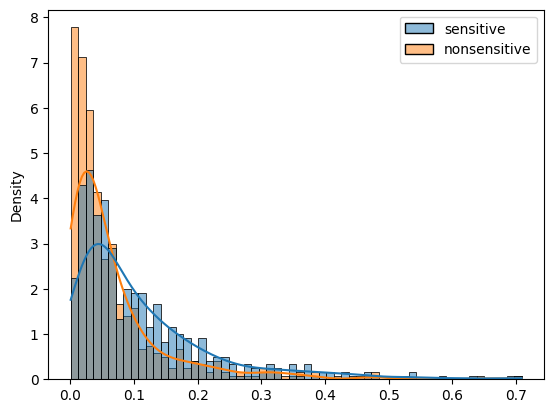

In [15]:
for (f, l), (non_f, non_l) in zip(
    dataset_train_sensitive.take(1), dataset_train_nonsensitive.take(1)
):
    res = tf.squeeze(baseline_model(f))
    non_res = tf.squeeze(baseline_model(non_f))
    sns.histplot(
        {"sensitive": res, "nonsensitive": non_res},
        bins=60,
        kde=True,
        stat="density",
    )

### Train and evaluate the model

To train with MinDiff, simply take the original model and wrap it in a MinDiffModel with a corresponding `loss` and `loss_weight`.  We are using 1.5 as the default `loss_weight`, but this is a parameter that needs to be tuned for your use case, since it depends on your model and product requirements.  You can experiment with changing the value to see how it impacts the model, noting that increasing it pushes the performance of the minority and majority groups closer together but may come with more pronounced tradeoffs.

Then we compile the model normally (using the regular non-MinDiff loss) and fit to train.

#### Train MinDiffModel

In [16]:
base_dir = tempfile.mkdtemp(prefix="saved_models")
min_diff_model_location = os.path.join(base_dir, "model_export_min_diff")


min_diff_weight = 1.5

# Create the dataset that will be passed to the MinDiffModel during training.
min_diff_dataset = md.keras.utils.input_utils.pack_min_diff_data(
    dataset_train_main, dataset_train_sensitive, dataset_train_nonsensitive
)

original_model = tf.keras.Sequential()

# Create the original model.
hub_layer = hub.KerasLayer(
    hub_url, output_shape=[128], input_shape=[], dtype=tf.string
)

original_model.add(hub_layer)
original_model.add(tf.keras.layers.Dense(128, activation="relu"))
original_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

baseline_model = min_diff_keras_utils.create_keras_sequential_model()

# Wrap the original model in a MinDiffModel, passing in one of the MinDiff
# losses and using the set loss_weight.
min_diff_loss = md.losses.MMDLoss()
min_diff_model = md.keras.MinDiffModel(
    original_model, min_diff_loss, min_diff_weight
)

# Compile the model normally after wrapping the original model.  Note that
# this means we use the baseline's model's loss here.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
min_diff_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

min_diff_model.fit(min_diff_dataset, epochs=30)

min_diff_model.save_original_model(min_diff_model_location, save_format="tf")

Epoch 1/30
25/25 [==============================] - 3s 23ms/step - loss: 0.4426 - accuracy: 0.9155 - min_diff_loss: 0.0045
Epoch 2/30
25/25 [==============================] - 1s 22ms/step - loss: 0.3312 - accuracy: 0.9185 - min_diff_loss: 0.0036
Epoch 3/30
25/25 [==============================] - 1s 23ms/step - loss: 0.3137 - accuracy: 0.9186 - min_diff_loss: 0.0026
Epoch 4/30
25/25 [==============================] - 1s 22ms/step - loss: 0.2974 - accuracy: 0.9186 - min_diff_loss: 0.0025
Epoch 5/30
25/25 [==============================] - 1s 22ms/step - loss: 0.2829 - accuracy: 0.9186 - min_diff_loss: 0.0021
Epoch 6/30
25/25 [==============================] - 1s 23ms/step - loss: 0.2709 - accuracy: 0.9186 - min_diff_loss: 0.0016
Epoch 7/30
25/25 [==============================] - 1s 22ms/step - loss: 0.2616 - accuracy: 0.9186 - min_diff_loss: 0.0014
Epoch 8/30
25/25 [==============================] - 1s 22ms/step - loss: 0.2546 - accuracy: 0.9186 - min_diff_loss: 0.0014
Epoch 9/30
25/25

INFO:tensorflow:Assets written to: /var/tmp/saved_modelsky_7w42k/model_export_min_diff/assets


INFO:tensorflow:Assets written to: /var/tmp/saved_modelsky_7w42k/model_export_min_diff/assets


Next we evaluate the results.  

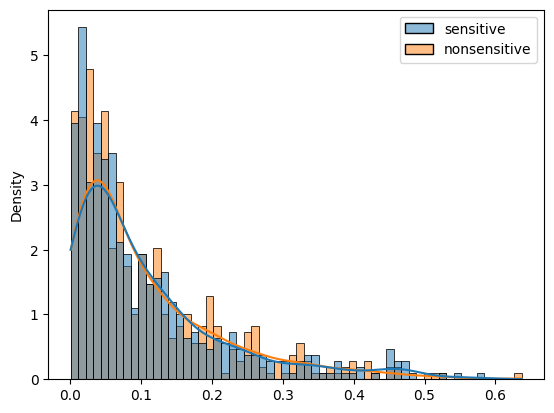

In [17]:
for (f, l), (non_f, non_l) in zip(
    dataset_train_sensitive.take(1), dataset_train_nonsensitive.take(1)
):
    res = tf.squeeze(min_diff_model(f))
    non_res = tf.squeeze(min_diff_model(non_f))
    sns.histplot(
        {"sensitive": res, "nonsensitive": non_res},
        bins=60,
        kde=True,
        stat="density",
    )

In [ ]:
# min_diff_eval_subdir = os.path.join(base_dir, 'tfma_eval_result')
# min_diff_eval_result = fi_util.get_eval_results(
#     min_diff_model_location,
#     min_diff_eval_subdir,
#     validate_tfrecord_file,
#     slice_selection='religion')

To ensure we evaluate a new model correctly, we need to select a threshold the same way that we would the baseline model. In a production setting, this would mean ensuring that evaluation metrics meet launch standards. In our case, we will pick the threshold that results in a similar overall FPR to the baseline model. This threshold may be different from the one you selected for the baseline model.  Try selecting false positive rate with threshold 0.400.  (Note that the subgroups with very low quantity examples have very wide confidence range intervals and don’t have predictable results.)   

Reviewing these results, you may notice that the FPRs for our target groups have improved. The gap between our lowest performing group and the majority group has improved from .024 to .006. Given the improvements we’ve observed and the continued strong performance for the majority group, we’ve satisfied both of our goals. Depending on the product, further improvements may be necessary, but this approach has gotten our model one step closer to performing equitably for all users.